In this notebook, we use TACTiCS to match cell types from human and mouse using ProtBERT embeddings.

In [1]:
from tactics import TACTiCS
from genes import embed_proteins, calc_dist

### Loading data
We define a dictionary for each species containing the species `name`, path to the protein `sequences`, path to the protein `embeddings`, path to the raw `counts` and the `column` name that should be used as cell type. Here, we use a 50k subset from the Allen Brain Data, which can be downloaded from [Zenodo](https://doi.org/10.5281/zenodo.7582460).

In [2]:
human = dict(name="Human",
             sequences="data/human_proteins.fasta",
             embeddings="data/human_proteins_emb.pkl",
             counts="data/human_50k.h5ad",
             column="Subclass")

mouse = dict(name="Mouse",
             sequences="data/mouse_proteins.fasta",
             embeddings="data/mouse_proteins_emb.pkl",
             counts="data/mouse_50k.h5ad",
             column="Subclass")

### Creating ProtBERT embeddings
`embed_proteins` creates a ProtBERT embedding for every protein sequence in `sequences`. By default, the embeddings are saved in `*_emb.pkl`. Because this is a time expensive step, we also provide the calculated embeddings.

In [ ]:
embed_proteins(human)
embed_proteins(mouse)

### Calculating initial gene matches
`calc_dist` calculates and saves the protein embedding distances using the cosine distance in a sparse format. Alternatively, `calc_dist_blast` can be used to convert BLAST distances to a similar format.

In [3]:
calc_dist(human, mouse, "data/human_mouse_dist.pkl")

gene matches saved to data/human_mouse_dist.pkl


### Training TACTiCS
`TACTiCS` initializes the model for a comparison between two species, at a specific resolution (in this case Subclass). The two scRNA-seq datasets are first normalized after which the highly variable genes are calculated separately per species. The gene distances are used to create gene matches, which are filtered using the highly variable genes. Finally, the datasets are subset to the relevant genes only.

In [4]:
model = TACTiCS(human, mouse, "data/human_mouse_dist.pkl")

C:\Users\kirti\miniconda3\envs\pytorch39\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
C:\Users\kirti\miniconda3\envs\pytorch39\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
C:\Users\kirti\miniconda3\envs\pytorch39\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\kirti\miniconda3\envs\pytorch39\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


`train` trains the model for 200 epochs. In every epoch, batches of 5000 cells are sampled from the dataset. To account for smaller cell types, a similar amount of cells is sampled from each cell type. After the model is trained, `transfer` transfers the cell types and creates the cell embeddings.

In [5]:
model.train()
model.transfer()

100%|██████████| 200/200 [10:50<00:00,  3.25s/it]


### Saving and loading model
The dictionaries, trained weights and preprocessed/subset scRNA-seq datasets can be stored using `save` and providing a directory.

In [6]:
model.save("data/human_mouse_subclass")

The saved model can be loaded by providing the directory when creating a `TACTiCS` object.

In [7]:
model = TACTiCS(folder="data/human_mouse_subclass")

### Plotting results
`plot_matches` plots the cell type matches resulting from `transfer`.

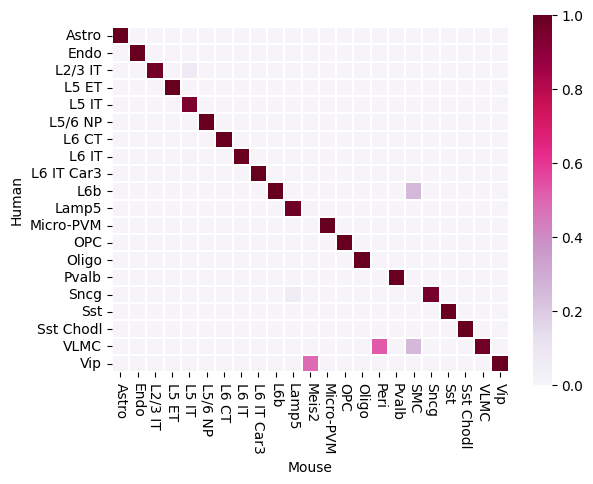

In [8]:
model.plot_matches()

`plot_embeddings` creates two UMAP plots using `scanpy.pl.umap` from the cell embeddings that were calculated in `transfer`.

C:\Users\kirti\miniconda3\envs\pytorch39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\kirti\miniconda3\envs\pytorch39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


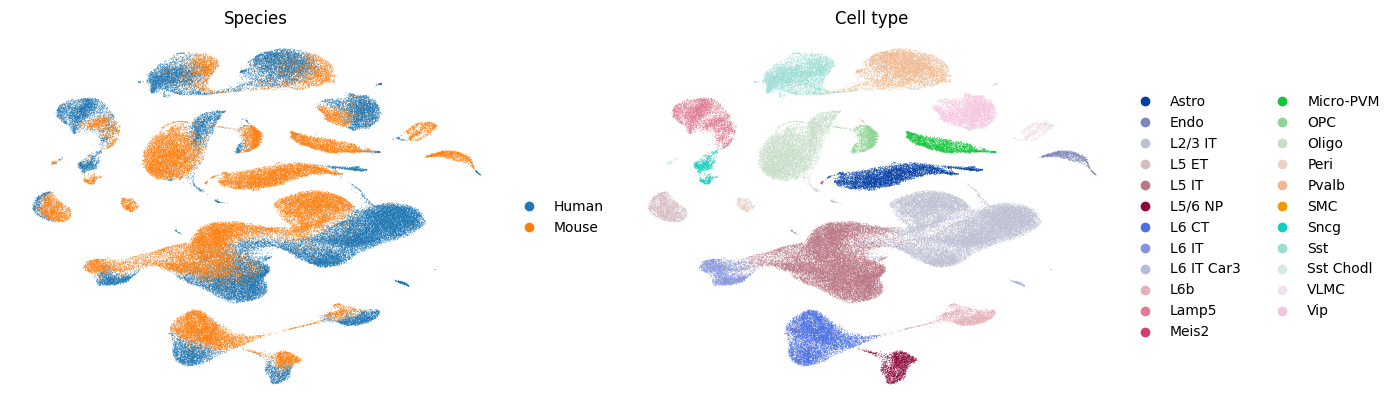

In [9]:
model.plot_embeddings()

The average diagonal score (ADS) and recall used to score the quality of the cell type matches can be calculated using `get_ADS` and `get_recall`.

In [10]:
model.get_ADS()
model.get_recall()

ADS: 0.9887756486630099
Recall: 1.0 20/20
